# Question 3 [Self Taught Neural Network Learning, 30 Marks]

## I. Load Task2C_labeled.csv, Task2C_unlabeled.csv and Task2C_test.csv data sets and required libraries (e.g., H2O). Note that we are going to use Task2C_labeled.csv and Task2C_unlabeled.csv for training the autoencoder. We are going to use Task2C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task2C_test.csv.

In [11]:
# set universal parameter
options(warn=-1)

In [13]:
# import H2O library
library(h2o)
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\Claude\AppData\Local\Temp\Rtmpe0DntL/h2o_Claude_started_from_r.out
    C:\Users\Claude\AppData\Local\Temp\Rtmpe0DntL/h2o_Claude_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 647 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.8 
    H2O cluster version age:    22 days  
    H2O cluster name:           H2O_started_from_R_Claude_zat179 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
  

In [15]:
# set absolute pat
train.file.task3.labeled <- '/Users/Claude/Downloads/assignment2_datasets/Task2C_labeled.csv'
train.file.task3.unlabeled <- '/Users/Claude/Downloads/assignment2_datasets/Task2C_unlabeled.csv'
train.file.task3.test <- '/Users/Claude/Downloads/assignment2_datasets/Task2C_test.csv'

# import labeled training data
labeled.frame <- h2o.importFile(path = train.file.task3.labeled,sep=',') 
# import unlabeled training data
unlabeled.frame <- h2o.importFile(path = train.file.task3.unlabeled, sep=',') 
# import test data
test.frame <- h2o.importFile(path = train.file.task3.test, sep=',') 

# create labels
labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA

# create combined training frame for training autoencoder
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## II. Train an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, .., 500 (i.e. from 20 to 500 with a step size of 20).

In [16]:
# refers to assignment2 codebase A2Q3 and tutorial code
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

# define the error function
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}


In [17]:
# Create to matrix to record error
reconstruction.train.error <- matrix(NA, nrow=25, ncol=2)
classification.test.error <- matrix(NA, nrow=25, ncol=2)

# Initial index
i <- 1

In [18]:
for (k in seq(20,500,20)){
  
  # question II: training autoencoder for the combined train frame
  Autoencoder.model = h2o.deeplearning(    
    x = 2:ncol(train.frame), # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = k, # number of layers and their units
    epochs = 50, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
  )
  # record reconstruction error
  reconstruction.train.error[i,1] <- k
  reconstruction.train.error[i,2] <- mean(h2o.anomaly(Autoencoder.model,train.frame))
  
  
  # Question V
  # Combine middle layer feature with labeled.frame data
  middle.layer.feature <- as.h2o(h2o.deepfeatures(Autoencoder.model, train.frame, layer=1))
  combined.train.frame <- h2o.cbind(labeled.frame,middle.layer.feature[1:nrow(labeled.frame),])
  
  # Training 3 layer NN model with 100 neurons
  NN.model <- h2o.deeplearning(    
    x = 2:ncol(combined.train.frame), # select all pixels + extra features
    y = 1,
    training_frame = combined.train.frame, # specify the frame (imported file)    
    hidden = c(100), # number of layers and their units
    epochs = 50, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = FALSE, # is it an autoencoder? Yes!
    l2 = 0.1
  )
  
  # Record classification error
  classification.test.error[i,1] <- ncol(labeled.frame) + k - 1  # calculate number of features
  test.predict <- h2o.predict(NN.model, test.frame)$predict
  classification.test.error[i,2] <- error.rate(test.frame$label, test.predict)
  
  # Increase index  
  i <- i + 1
}
print('done')

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

## III. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, save and attach the plot to your report, and explain your findings based on the plot.

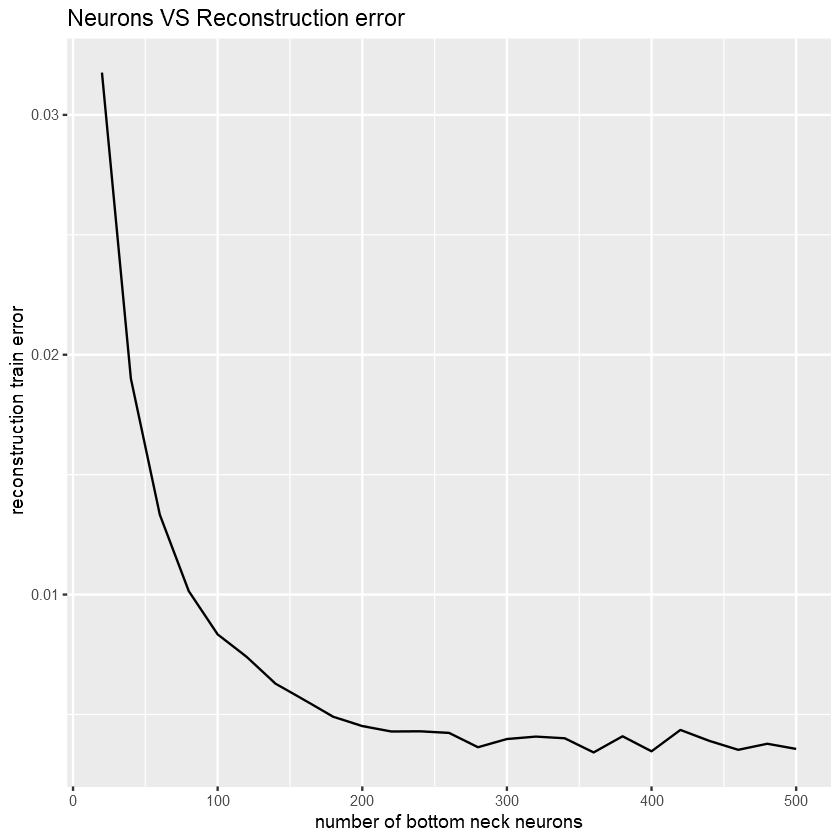

In [19]:
library(ggplot2)

# transform reconstruction error matrix to data frame 
reconstruction.train.error.df  <- as.data.frame(reconstruction.train.error)
names(reconstruction.train.error.df) <- c('k','error')
ggplot(data = reconstruction.train.error.df, aes(x=k,y=error)) + 
  geom_line() + 
  xlab('number of bottom neck neurons') +
  ylab('reconstruction train error') +
  ggtitle('Neurons VS Reconstruction error')


### Answer:

From the plot we can see, in the beginning, when the number of neurons in the middle layer increases, the reconstruction error decrease. However, as the number still increaing over 280, the reconstruction error increases slightly and starts fluctuating, which means the model may tend to be overfitting or can be explained as the model is unstable. From my personal opinion, this later increasing of reconstruction error is a reflection of unstability of our model.

This is because as an autoencoder learns to project the data onto its middle layer neurons, generally, if we have an autoencoder with n inputs and a hidden layer of dimension n (or more), it could potentially just end up learning the identity function. This is called overfitting and we should avoid it. However, even our model is overfitting, the reconstruction error should be close to 0 instead of increasing.

## IV. Use the 3-layer NN from Activity 3.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) to build a model with 100 units in the hidden layer using all the original attributes from the training set. Then, calculate and record the test error.

In [20]:
# build a neural network classifier based on the labeled training data
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(100), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)
print('done')

  |======================================================================| 100%
[1] "done"


In [21]:
# Calculate training error
labeled.predict <- h2o.predict(NN.model, labeled.frame)$predict
train.error <- error.rate(labeled.frame$label, labeled.predict)
# Calculate testing error
test.predict <- h2o.predict(NN.model, test.frame)$predict
test.error <- error.rate(test.frame$label, test.predict)

q4 <- data.frame(features=ncol(labeled.frame)-1, error=test.error)
q4

  |======================================================================| 100%
  |======================================================================| 100%


features,error
784,0.586


## V. Build augmented self-taught networks using the models learnt in Step II. For each model:
    A. Add the output of the middle layer as extra features to the original feature set, 
    B. Train a 3-layer NN (similar to Step IV) using all features (original + extra).

### See above question2

## VI. Plot the error rates for the 3-layer neural networks from Step IV and V while thex-axis is the number of features and y-axis is the classification error. Save the plot in your report.

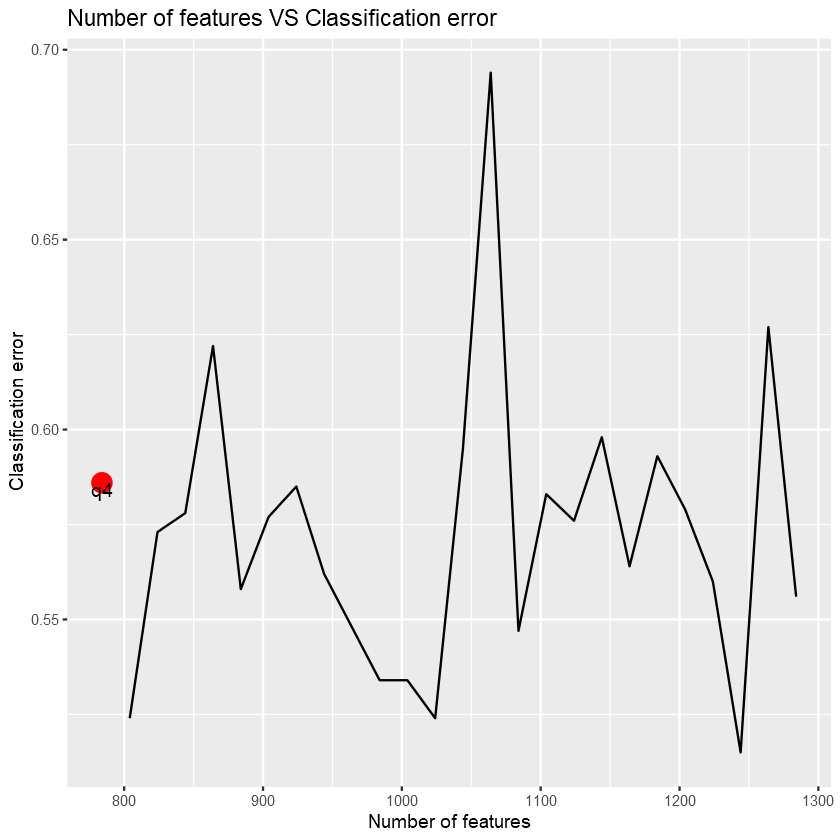

In [22]:
classification.test.error.df <- as.data.frame(classification.test.error)
names(classification.test.error.df) <- c('features','error')
ggplot(data = classification.test.error.df,aes(x=features,y=error)) +
  geom_line() + 
  geom_point(data=q4,color='red',size=5) +
  geom_text(data=q4, label='q4',vjust=1) +
  labs(x='Number of features',y='Classification error',title='Number of features VS Classification error ')

## VII. Report the optimum number(s) of units in the middle layer of the autoencoder in terms of the reconstruction and misclassification errors.


### Answer:

In terms of reconstruction and misclassification error, the optimum numbers of units are 280 and 400.

## VIII. Comparing the plot from Step III and VI, do you observe any relation between the reconstruction error and misclassification error? Explain your finding in your report.

### See the report